In [30]:
import networkx as nx
import pandas as pd
import os
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [31]:
# Using readlines()
file1 = open('Sprint/topology.txt', 'r')
Lines = file1.readlines()
 
edges = []
# Strips the newline character
for line in Lines[1:-1]:
    to_node, from_node, cap, _ = line.split()
    edges.append((int(from_node), int(to_node), int(cap)))

In [32]:
G = nx.Graph() #directed
G.add_weighted_edges_from(edges)
# nx.draw(G)
# edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G))
# labels = nx.draw_networkx_labels(G, pos=nx.circular_layout(G))

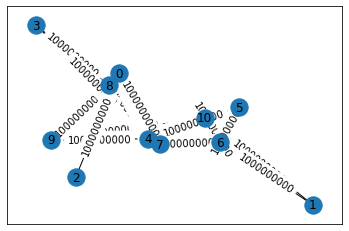

<Figure size 1080x1080 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.figure(3,figsize=(15,15))
plt.show()

In [34]:
# Using readlines()
file1 = open('Sprint/demand.txt', 'r')
line = file1.readlines()[43]
demand = [float(i) for i in line.split()]

print(len(demand))
print(demand)


# to_node, from_node, cap, _ = line.split()
# edges.append((int(to_node), int(from_node), int(cap)))

121
[54914.044043, 22388.739365, 104362.435679, 36097.284266, 18951.814223, 59129.785049, 44452.179824, 100627.563581, 15085.937182, 43054.758694, 145212.482087, 13101.234426, 8806.547291, 31970.293029, 10173.85944, 5805.681424, 19687.923698, 13617.440083, 28361.432403, 4621.412189, 13189.355373, 48350.121093, 2169.092867, 1135.528345, 9485.298296, 1830.808283, 1234.220484, 3259.611536, 2450.48816, 5547.23422, 831.633242, 2373.453379, 8005.039784, 27868.043875, 13422.552526, 68005.006236, 30202.634595, 12349.445814, 38530.352179, 26650.081046, 60328.486375, 9830.349833, 28055.488686, 94623.852783, 547937.083267, 286847.141885, 1716875.144201, 462482.619167, 368322.043114, 823414.278072, 619020.676779, 1401293.316925, 210079.844924, 599560.830776, 2022162.451741, 286006.519329, 162737.250024, 758580.26265, 241401.883898, 137755.238441, 708615.868393, 381709.359086, 731432.561095, 109655.299965, 340149.391699, 1246934.654005, 86197.25429, 45124.589641, 228622.536131, 66937.108424, 41516.

In [35]:
# Test running some functions
# G2 is a square fully connected graph
G2 = nx.DiGraph()
G2.add_edge(1, 2)
G2.add_edge(1, 4)
G2.add_edge(1, 3)

G2.add_edge(2, 3)
G2.add_edge(2, 4)

G2.add_edge(3, 4)

G2.add_edge(2, 1)
G2.add_edge(4, 1)
G2.add_edge(3, 1)

G2.add_edge(3, 2)
G2.add_edge(4, 2)

G2.add_edge(4, 3)

print(list(nx.dfs_edges(G2, 1)))
print(list(nx.edge_dfs(G2, 1)))
# print(list(nx.edge_dfs(G2, 2)))
# print(list(nx.edge_dfs(G2, 3)))
# print(list(nx.edge_dfs(G2, 4)))

[(1, 2), (2, 3), (3, 4)]
[(1, 2), (2, 3), (3, 4), (4, 1), (1, 4), (4, 2), (2, 4), (4, 3), (3, 1), (1, 3), (3, 2), (2, 1)]


In [36]:
# prints all paths from 1 to 4
for path in nx.all_simple_edge_paths(G2, 1, 4):
    print(path)

# each path is a variable

[(1, 2), (2, 3), (3, 4)]
[(1, 2), (2, 4)]
[(1, 4)]
[(1, 3), (3, 4)]
[(1, 3), (3, 2), (2, 4)]


In [37]:
#edges

In [38]:
# maximize sum of flow for all paths
demand = [float(i) for i in line.split()]
n = int(len(demand)**0.5)
demand = np.array(demand).reshape(n, n)
paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("sprint")

edges_vars = {} #maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({tail}, {head})<={capacity}') #assuming >= 0 is already added)

demand_vars = {}

for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

# for (src, dest, capacity) in edges:
#     edges_vars[(src, dest)] = (m.addVar(name=f'({src}, {dest})'), [])
#     m.addConstr(edges_vars[(src, dest)][0] <= capacity, f'({src}, {dest})<={capacity}')

objective = 0

for path in paths:
    p = m.addVar(name=f'{path}')
    objective += p

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

#relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# print(demand_vars)
for key in demand_vars:
    # print(demand_vars[key][0], sum(demand_vars[key][1]))
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# #demand constraint: demand over all paths from u to v <= demand from u to v
# n = len(demands)
# for i in range(n):
#     for j in range(n):
#         src, dest = i+1, j+1
#         demands = 0

# Set objective
m.setObjective(objective, GRB.MAXIMIZE)

# Optimize model
m.optimize()

for v in m.getVars():
    print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 163 rows, 4209 columns and 28227 nonzeros
Model fingerprint: 0xc232a41b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+02, 1e+09]
Presolve removed 163 rows and 4209 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8902118e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.890211801e+07
(9, 10) 0
(8, 9) 0
(4, 9) 0
(3, 8) 0
(7, 8) 0
(4, 8) 0
(8, 9) 1.29114e+06
(3, 8) 1.74175e+06
(3, 4) 0
(0, 2) 0
(1, 10) 0
(1, 6) 0
(0, 7) 0
(0, 4) 0
(0, 2) 3.58586e+06
(7, 10) 0
(7, 8) 3.44525e+06
(6, 7) 0
(0, 7) 3.82971e+06
(6,

In [39]:
# ALTERNATIVE SOLUTION
demand = [float(i) for i in line.split()]
n = int(len(demand)**0.5)
demand = np.array(demand).reshape(n, n)
paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("sprint")
######################### above is all the same
edges_vars = {}
for (src, dest, capacity) in edges:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (capacity, [])

demand_vars = {}
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

objective = 0

for path in paths:
    p = m.addVar(name=f'{path}')
    objective += p

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

# sum of flow over paths that use the edge <= capacity of edge
for key in edges_vars:
    m.addConstr(sum(edges_vars[key][1]) <= edges_vars[key][0])

# sum of flow on paths of demand <= demand
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# Set objective
m.setObjective(objective, GRB.MAXIMIZE)

# Optimize model
m.optimize()

for v in m.getVars():
    print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 128 rows, 4174 columns and 28174 nonzeros
Model fingerprint: 0xf92d628d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+02, 1e+09]
Presolve removed 128 rows and 4174 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8902118e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.890211801e+07
[(0, 7), (7, 8), (8, 9), (9, 10), (10, 1)] 0
[(0, 7), (7, 8), (8, 9), (9, 10), (10, 6), (6, 1)] 0
[(0, 7), (7, 8), (8, 9), (9, 10), (10, 4), (4, 5), (5, 6), (6, 1)] 0
[(0, 7), (7, 8), (8, 9), (9, 4), (4, 5), (5, 6), (6, 1)] 0
[

In [42]:
# min the max problem - MLU
demand = [float(i) for i in line.split()]
n = int(len(demand)**0.5)
demand = np.array(demand).reshape(n, n)
paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("ibm")

#new variable for MLU
MLU = m.addVar(name="MLU")

edges_vars = {} #maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({src}, {tail})<={head}') #assuming >= 0 is already added)
    m.addConstr(edges_vars[(tail, head)][0] / capacity <= MLU)

demand_vars = {}

n = len(demand)
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

# for (src, dest, capacity) in edges:
#     edges_vars[(src, dest)] = (m.addVar(name=f'({src}, {dest})'), [])
#     m.addConstr(edges_vars[(src, dest)][0] <= capacity, f'({src}, {dest})<={capacity}')


for path in paths:
    p = m.addVar(name=f'{path}')

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

#relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# print(demand_vars)
for key in demand_vars:
    # print(demand_vars[key][0], sum(demand_vars[key][1]))
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# #demand constraint: demand over all paths from u to v <= demand from u to v
# n = len(demands)
# for i in range(n):
#     for j in range(n):
#         src, dest = i+1, j+1
#         demands = 0

# Set objective
m.setObjective(MLU, GRB.MINIMIZE)

# Optimize model
m.optimize()

for v in m.getVars():
    print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 198 rows, 4210 columns and 28297 nonzeros
Model fingerprint: 0x388f6f20
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+02, 1e+09]
Presolve removed 198 rows and 4210 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  0.000000000e+00
MLU 0
(9, 10) 0
(8, 9) 0
(4, 9) 0
(3, 8) 0
(7, 8) 0
(4, 8) 0
(8, 9) 0
(3, 8) 0
(3, 4) 0
(0, 2) 0
(1, 10) 0
(1, 6) 0
(0, 7) 0
(0, 4) 0
(0, 2) 0
(7, 10) 0
(7, 8) 0
(6, 7) 0
(0, 7) 0
(6, 10) 0
(6, 7) 0
(1, 6) 0
(5, 6) 0
(4, 5) 0
(